## Load Data ##

<Axes: xlabel='team_id_home', ylabel='Wins'>

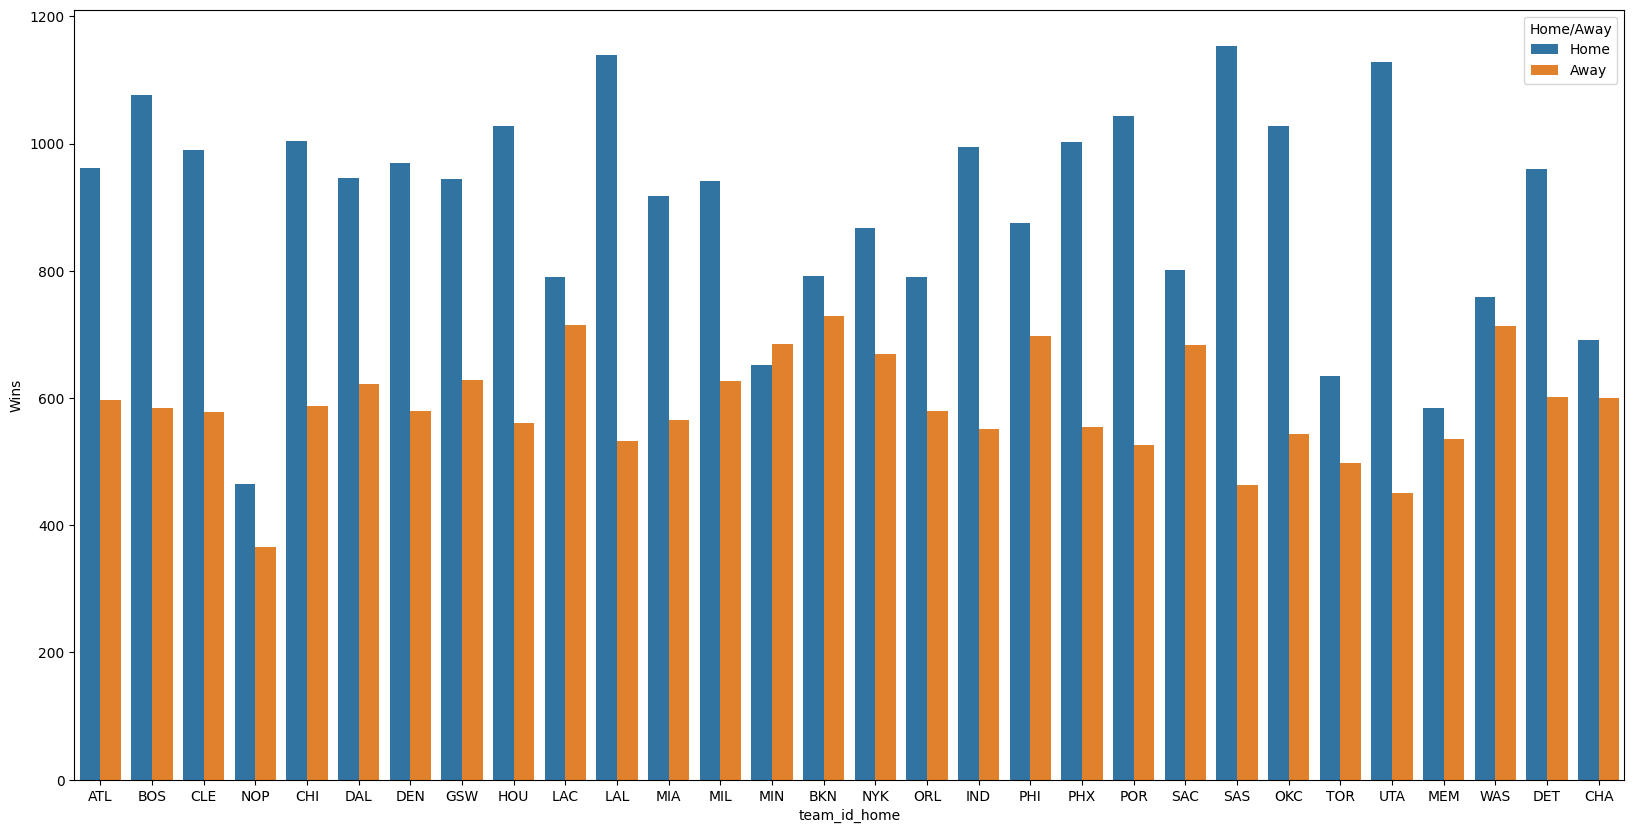

In [131]:
## Load pickle files and apply label encoding on team id ##

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

with open('NBA_Data_Cleaned_df.pickle', 'rb') as file:
    nba_df = pickle.load(file)

with open('teamID_mappings.pickle', 'rb') as file:
    team_mappings = pickle.load(file)
    teamID_newID_dict = team_mappings['teamID_newID_dict']
    teamID_abbreviation_dict = team_mappings['teamID_abbreviation_dict']

newID_abbreviation_dict = { tID_nID_value : tID_abbreviation_value  for  (tID_nID_key, tID_nID_value), (tID_abbreviation_key, tID_abbreviation_value) in zip(teamID_newID_dict.items(), teamID_abbreviation_dict.items()) }

nba_df[['team_id_home', 'team_id_away']] = nba_df[['team_id_home', 'team_id_away']].replace(teamID_newID_dict)

plot_home_wins = nba_df.groupby('team_id_home').sum(numeric_only=True).reset_index().loc[:,['team_id_home', 'wl_home', 'wl_away']].replace(newID_abbreviation_dict)
plot_home_wins.rename(columns={'wl_home' : 'Home', 'wl_away' : 'Away'}, inplace=True)

plot_home_wins = plot_home_wins.melt(id_vars='team_id_home', value_vars=['Home', 'Away'] ,var_name='Home/Away', value_name='Wins')


plt.figure(figsize=(20,10))
sns.barplot(x='team_id_home', y='Wins', hue='Home/Away', data=plot_home_wins)




In [132]:
import pickle
import pandas as pd
import numpy as np

def loadNbaData():
    with open('NBA_Data_Cleaned_df.pickle', 'rb') as file:
        nba_df = pickle.load(file)

    with open('teamID_mappings.pickle', 'rb') as file:
        team_mappings = pickle.load(file)
        teamID_newID_dict = team_mappings['teamID_newID_dict']
        
    nba_df[['team_id_home', 'team_id_away']] = nba_df[['team_id_home', 'team_id_away']].replace(teamID_newID_dict)

    X_df = nba_df.drop(columns=['season_id', 'new_season_id', 'wl_home', 'game_date', 'wl_away', 'fg_pct_home'])
    y_df = nba_df.loc[ : , 'wl_home' ]

    print(X_df.columns)

    X = X_df.to_numpy()
    y = y_df.to_numpy()

    return X,y

X,y = loadNbaData()

print("X shape: ", X.shape)
print("y shape: ", y.shape)


Index(['team_id_home', 'fga_home', 'fg3a_home', 'oreb_home', 'dreb_home',
       'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
       'team_id_away', 'fga_away', 'fg3a_away', 'oreb_away', 'dreb_away',
       'ast_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away',
       'season_type', 'rest_days_home', 'rest_days_away'],
      dtype='object')
X shape:  (44549, 23)
y shape:  (44549,)


In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (40094, 23)
X_test shape:  (4455, 23)
y_train shape:  (40094,)
y_test shape:  (4455,)


## Logistic Regression ##

In [134]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'elasticnet', 'l1'],
    'solver': ['saga'],
    }

gsCV = GridSearchCV(LogisticRegression(), param_grid, cv=StratifiedKFold(10, shuffle=True, random_state=42), n_jobs=-1)

gsCV.fit(X_train, y_train)


/opt/anaconda3/envs/cs5100/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/cs5100/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/cs5100/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/cs5100/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/cs5100/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/cs5100/lib/python3.11/sit

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'elasticnet', 'l1'],
                         'solver': ['saga']})

### Note ###
liblinear a very long time to converge for minimum improvement (<+0.001% improvement), so that option has been removed from solvers.

In [135]:
y_pred = gsCV.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix
print("Best Parameters:", gsCV.best_params_)
print("Best CV Score: ",gsCV.best_score_)
print(f"Accuracy: {(accuracy_score(y_test, y_pred) * 100)}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best CV Score:  0.8789594733545284
Accuracy: 88.01346801346801%
Confusion Matrix:
 [[1460  287]
 [ 247 2461]]


## Gaussian Naive Bayes ##

In [136]:
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

gsCV_gnb = GridSearchCV(GaussianNB(), param_grid, cv=StratifiedKFold(10, shuffle=True, random_state=42), n_jobs=-1)

gsCV_gnb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06,
                                           1e-05]})

In [137]:
y_pred_gNB = gsCV_gnb.predict(X_test)

print("Best Parameters:", gsCV_gnb.best_params_)
print("Best CV Score: ",gsCV_gnb.best_score_)
print(f"Accuracy: {(accuracy_score(y_test, y_pred_gNB) * 100)}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gNB))


Best Parameters: {'var_smoothing': 1e-05}
Best CV Score:  0.8177783963637925
Accuracy: 82.28956228956228%
Confusion Matrix:
 [[1293  454]
 [ 335 2373]]
